# RST Mask RCNN Pipeline for Anomaly Detection

Pipeline modified to support Roman Space Telescope (RST) data and preprocessing requirements. This notebook includes preprocessing, training, and prediction. The main Mask RCNN has been taken from torchvision for additional flexibility and tuning. The training labels are Float based, thus we are transforming values greater than 0 to 1.

Note that this is only an Exploratory Data Analysis notebook. For a production application I recommend adding the following features:

- Earlystopping
- Validation accuracy monitoring
- IoU monitoring
- Best model save

Feel free to reach out if you need help adding any of these features.

TODO:
- configuration settings (add additional flexibility for choices of optimizers and losses)
- training pipeline (references: https://www.kaggle.com/abhishek/mask-rcnn-using-torchvision-0-17/notebook)
- inference pipeline (references: https://www.kaggle.com/abhishek/inference-for-mask-rcnn)
- Make sure this is not only binary, and that we can extract other types of data (1, 2, 3, etc.)
- save best model only
- select best model only

References:
- [Transforms for data augmentation](https://github.com/pytorch/vision/blob/main/torchvision/transforms/functional_tensor.py)
- [Finetuning and transfer learning notebook](https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/torchvision_finetuning_instance_segmentation.ipynb#scrollTo=6-NFR--2fXV3)
- [Mask RCNN Example](https://www.kaggle.com/abhishek/mask-rcnn-using-torchvision-0-17/notebook)

Author: Jordan A. Caraballo-Vega - NASA GSFC, jordan.a.caraballo-vega@nasa.gov  
Release Date: 07/23/2021  
Version: 2021.10  

## 1. Usage and installation requirements

### 1.1 Creating a conda environment (One time only)

In order to run this notebook you will need a conda environment with all dependencies installed. ADAPT provides a built-in environment from the JupyterHub interface that is only missing a couple of packages that can be installed on the fly. In order to get started quickly, follow the next steps:

1. Login to adaptlogin.nccs.nasa.gov
2. Load the Anaconda module

```bash
module load anaconda3
```

3. Clone the existing environment

```bash
conda create --name slump-detection-11.1 --clone /att/nobackup/jacaraba/.conda/envs/slump-detection-11.1
```

Now you are ready to move on to JupyterHub.

### 1.2 Login to ADAPT JupyterHub

To leverage NCCS ADAPT resources, you will need to login to ADAPT JupyterHub. The steps are outlined below.

1. Login to the NCCS JupyterHub https://www-proxy-dev.nccs.nasa.gov/jupyterhub-prism/.
2. Open this notebook via the file/upload method.
3. Select kernel, in this case "ilab-kernel".
4. Start working on your notebook.


## 2. Define global variables for the CNN pipeline

The configuration file is a yaml file with all the options for this notebook to run. If you do not want to use a yaml file you can also set a new object in this notebook that will overrride the contents set in the yaml file. An example of this is listed below. The variables from the yaml file are documented below.


In [1]:
configuration_file = 'maskrcnn.yaml'
PREPROCESS = True
VIS = True
TRAIN = True
PREDICT = True

### 2.1 Import Python Libraries

In this section we include all Python libraries required to execute the code below. There are no external code dependencies besides the packages installed under section 1.1.

In [2]:
import os
import sys
import glob
import time
import errno
import pickle
import datetime
from tqdm import tqdm
from pathlib import Path
from omegaconf import OmegaConf

import collections
from __future__ import print_function
from collections import defaultdict, deque

import h5py
import numpy as np
import pandas as pd
from PIL import Image, ImageFile

import torch
import torch.utils.data
import torch.distributed as dist

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.patches as mpatches
from matplotlib import patches

sys.path.append('../rst_anomaly_detection')

from config import Config
from utils.coco import gen_data_pairs, gen_coco_dataset
from utils.base import SmoothedValue, MetricLogger
from utils.base import collate_fn, warmup_lr_scheduler, reduce_dict
from dataset import transforms as vision_transforms

ImageFile.LOAD_TRUNCATED_IMAGES = True

## 2.2 Read Configuration File

In [3]:
# Configuration file intialization
schema = OmegaConf.structured(Config)
conf = OmegaConf.load(configuration_file)
try:
    conf = OmegaConf.merge(schema, conf)
except BaseException as err:
    sys.exit(f"ERROR: {err}")

## 3. Preprocessing - Preparing the Data

In this stage we are going to prepare the data for training. The steps can be summarized as follow:
- List all files in directory for training
- For each file:
  - Read the data
  - Extract frame and label
  - Extract tile with data
  - Preprocess
  - Save "RGB" tile (basically a normalize numpy array with matching label)
  - Create dataset file
  
Explain the data format we need for this.

### 3.1 Generate Dataset

First we list the files that we want to use to generate the training, validation, and test datasets.

In [4]:
if PREPROCESS:
    data_filenames = glob.glob(conf.data_regex)
    print('Number of available files: ', len(data_filenames))

Number of available files:  2


Then we go ahead and start extracting our training dataset. Note that based on your use case, this step might be completely different. Here we are processing HDF5 files, and extracting really small features from the data. In other use cases you might have different sets of the data.

In [5]:
if PREPROCESS:

    for filename in data_filenames:

        print('Filename is: ', Path(filename).stem)

        # read filename and get keys
        file = h5py.File(filename, 'r')

        for frame_id in file.keys(): # e.g. Frame0001, Frame002, etc.
            
            print(f'{frame_id}/ActualFrame') # names of the groups in HDF5 file
            
            # set data array
            data = file[frame_id]['ActualFrame'][()]  # extract data array
            data = np.repeat(data[:, :, np.newaxis], 3, axis=-1)  # we need 3D images
            
            # lets normalize the data here            
            data = data / 65535.0

            # get tiles for each set of classes
            for label_value, class_id in enumerate(conf.classes):
                
                label_value = label_value + 1  # enumerate starts from 0

                # set labels for data selection
                label = file[frame_id][class_id][()]  # extract label array
                label[label > 0] = label_value # values greater than 0, set to label_value

                # count number of true pixels in frame
                number_of_true_pixels = np.count_nonzero(label == label_value)

                print(f'Data:  {data.shape}, {data.min()}, {data.max()}')
                print(f'Labels (number of true pixels): {number_of_true_pixels}')

                # if the number of true pixels in the frame is less than 4, exclude this frame
                if number_of_true_pixels < 4:
                    continue

                # experiment id to save individual tiles
                experiment_id = f'{Path(filename).stem}_{frame_id}_{class_id}'

                # extract tiles from the imagery and generate masks
                for dataset in ['train', 'test', 'val']:

                    # this is assuming each mask has 1 as the label_value
                    gen_data_pairs(
                        filename=experiment_id, data=data, label=label,
                        config=conf, set=dataset, label_value=label_value)

Filename is:  test_dark_200sec_cr_8_solution
Frame_0001/ActualFrame
Data:  (4096, 4096, 3), 0.0, 0.7572899977111467
Labels (number of true pixels): 2
Frame_0002/ActualFrame
Data:  (4096, 4096, 3), 0.0, 1.0
Labels (number of true pixels): 14
Frame_0003/ActualFrame
Data:  (4096, 4096, 3), 0.0, 1.0
Labels (number of true pixels): 3
Filename is:  test_dark_200sec_cr_4_solution
Frame_0001/ActualFrame
Data:  (4096, 4096, 3), 0.0, 0.863889524681468
Labels (number of true pixels): 1
Frame_0002/ActualFrame
Data:  (4096, 4096, 3), 0.0, 0.9568017090104525
Labels (number of true pixels): 4
Frame_0003/ActualFrame
Data:  (4096, 4096, 3), 0.0, 1.0
Labels (number of true pixels): 13


### 3.2 Generate COCO Dataset

The Mask RCNN network takes the dataset as COCO format. For this, we need to create three JSON files including training, validation, and test datasets.

In [6]:
if PREPROCESS:

    for dataset in ['train', 'test', 'val']:
        gen_coco_dataset(
            data_regex='*_img_*.npy', label_regex='*_lbl_*.npy', config=conf, set=dataset)

Number of train and mask images: 10 0 without annotations.
Number of train and mask images: 10 0 without annotations.
Number of train and mask images: 10 0 without annotations.


### 3.3 Visualize some of the tiles for training

Here we visualize some of the tiles seleted for training. We just want to make sure our training samples exist and look appropiate for training. Additional computer vision technicas can be used to improve these plots if the user wants to look at the tiles in more detail.

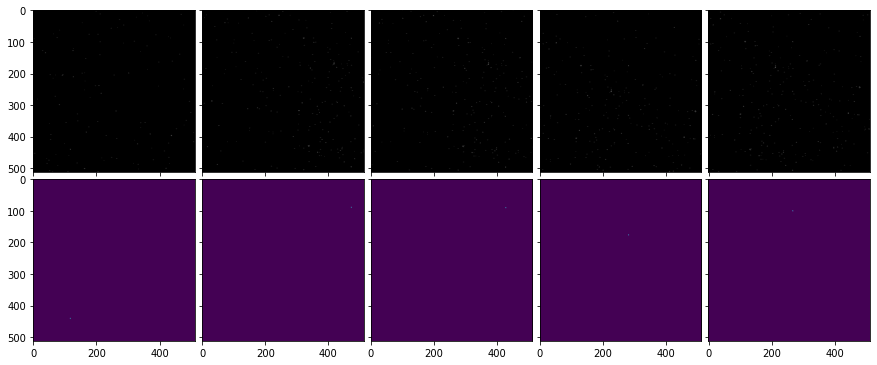

In [7]:
if VIS:

    vis_dir = os.path.join(conf.data_dir, 'train')
    images = sorted(glob.glob(os.path.join(vis_dir, '*_img_*.npy')))[:5]
    labels = sorted(glob.glob(os.path.join(vis_dir, '*_lbl_*.npy')))[:5]

    fig = plt.figure(figsize=(15, 15))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(2, 5),  # creates 2x2 grid of axes
                     axes_pad=0.1,  # pad between axes in inch.
                     )

    for ax, im_id in zip(grid, images + labels):
        # Iterating over the grid returns the Axes.
        ax.imshow(np.load(im_id), cmap='viridis')

    plt.show()

## 4. Training

In this section we prepare to train our model.

### 4.1 Defining training functions

#### Epoch Training

Define function to train one epoch. This will be useful in case we need to train differently based on the features we are trying to identify. Support for multi-gpu training. Would be nice to include mixed precision in a future version.

In [8]:
class Trainer:
    
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset = None,
                 lr_scheduler: torch.optim.lr_scheduler = None,
                 epochs: int = 100,
                 epoch: int = 0,
                 notebook: bool = False,
                 save_path: str = 'model.pkl'
                 ):

        self.model = model
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.device = device
        self.epochs = epochs
        self.epoch = epoch
        self.notebook = notebook
        self.save_path = save_path

        self.training_loss = []
        self.validation_loss = []
        self.learning_rate = []

    def run_trainer(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        for i in range(self.epochs):
            
            """Epoch counter"""
            self.epoch += 1  # epoch counter

            """Training block"""
            self._train()

            """Validation block"""
            if self.validation_DataLoader is not None:
                self._validate()

            """Learning rate scheduler block"""
            if self.lr_scheduler is not None:
                if self.validation_DataLoader is not None and self.lr_scheduler.__class__.__name__ == 'ReduceLROnPlateau':
                    self.lr_scheduler.batch(self.validation_loss[i])  # learning rate scheduler step with validation loss
                else:
                    self.lr_scheduler.batch()  # learning rate scheduler step
        
            torch.save(self.model.state_dict(), f"{Path(self.save_path).with_suffix('')}_{i}.pkl")
        
        torch.save(self.model.state_dict(), self.save_path)
        return self.training_loss, self.validation_loss, self.learning_rate

    def _train(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.train()  # train mode
        metric_logger = MetricLogger(delimiter="  ")
        metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
        header = 'Epoch: [{}]'.format(self.epoch)
        print_freq = 10
        
        if self.epoch == 0:
            warmup_factor = 1. / 1000
            warmup_iters = min(1000, len(data_loader) - 1)
            lr_scheduler = warmup_lr_scheduler(self.optimizer, warmup_iters, warmup_factor)
        
        train_losses = []  # accumulate the losses here
        for images, targets in metric_logger.log_every(self.training_DataLoader, print_freq, header):
            
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = self.model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            # reduce losses over all GPUs for logging purposes
            loss_dict_reduced = reduce_dict(loss_dict)
            losses_reduced = sum(loss for loss in loss_dict_reduced.values())
            train_losses.append(losses_reduced)

            # set the optimizer and update gradients
            self.optimizer.zero_grad()
            losses.backward()
            self.optimizer.step()

            metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
            metric_logger.update(lr=self.optimizer.param_groups[0]["lr"])

        self.training_loss.append(train_losses)
        self.learning_rate.append(self.optimizer.param_groups[0]['lr'])
        return

    def _validate(self):

        if self.notebook:
            from tqdm.notebook import tqdm, trange
        else:
            from tqdm import tqdm, trange

        self.model.eval()  # evaluation mode
        
        metric_logger = MetricLogger(delimiter="  ")
        metric_logger.add_meter('lr', SmoothedValue(window_size=1, fmt='{value:.6f}'))
        header = 'Epoch Val: [{}]'.format(self.epoch)
        print_freq = 10
        
        valid_losses = []  # accumulate the losses here
        for images, targets in metric_logger.log_every(self.validation_DataLoader, print_freq, header):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            with torch.no_grad():
                
                loss_dict = self.model(images, targets)                
                losses = sum(loss for loss in loss_dict)
                
                # reduce losses over all GPUs for logging purposes
                loss_dict_reduced = reduce_dict(loss_dict)                
                losses_reduced = sum(loss for loss in loss_dict_reduced.values())
                valid_losses.append(losses_reduced)
                metric_logger.update(loss=losses_reduced, **loss_dict_reduced)

        self.validation_loss.append(valid_losses)
        return

### 4.2 Defining dataset functions

This dataset is the one used to feed data to the model. By havign a custom dataset we are able to better modify how we input data to the model, and how our underlying data reads it. We will use RGB images to start since using single band images since gray scale images were not very effective.

In [9]:
class SegmentationDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_regex, label_regex, transforms=None):
        
        # set global attributes to read imagery and transforms during training
        self.data_regex = data_regex
        self.label_regex = label_regex
        self.transforms = transforms
        
        # load all image files, sorting them to ensure that they are aligned
        self.images = list(sorted(glob.glob(data_regex)))
        self.masks = list(sorted(glob.glob(label_regex)))

    def __getitem__(self, idx):
        
        img = np.load(self.images[idx])
        mask = np.load(self.masks[idx])
        
        # instances are encoded as different colors
        # first id is the background, so remove it
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax + 3, ymax + 3])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # there is only one class at this time
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.images)

### 4.3 Define transforms and data augmentation

Define any data augmentation techniques for the current dataset.

In [10]:
def get_transform_list(train=True):
    transforms = []
    #transforms.append(vision_transforms.ToTensor())
    transforms.append(vision_transforms.NumpyToTensor())
    if train:
        # one could add additional transformations here
        transforms.append(vision_transforms.RandomHorizontalFlip(0.5))
    return vision_transforms.Compose(transforms)

### 4.4 Define model and model parameters

In [11]:
def get_model_instance_segmentation(num_classes, pretrained=False):
    
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=pretrained)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask, hidden_layer, num_classes)

    return model

### 4.5 Define datasets and dataloaders for training

In this section we define the datasets and dataloaders for training.

In [12]:
if TRAIN:

    dataset_train = SegmentationDataset(
        data_regex=os.path.join(conf.data_dir, 'train/*img*'),
        label_regex=os.path.join(conf.data_dir, 'train/*lbl*'),
        transforms=get_transform_list(train=True))
    
    dataset_val = SegmentationDataset(
        data_regex=os.path.join(conf.data_dir, 'val/*img*'),
        label_regex=os.path.join(conf.data_dir, 'val/*lbl*'),
        transforms=get_transform_list(train=False))

    data_loader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=conf.batch_size, shuffle=True, collate_fn=collate_fn)

    data_loader_val = torch.utils.data.DataLoader(
        dataset_val, batch_size=conf.batch_size, shuffle=False, collate_fn=collate_fn)

### 4.6 Get model and model parameters

In [13]:
if TRAIN:

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # get the number of classes
    if len(conf.classes) == 1:
        num_classes = 2
    else:
        num_classes = len(conf.classes)

    # get the model using the helper function
    model = get_model_instance_segmentation(
        num_classes=num_classes, pretrained=conf.pretrained).to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(
        params, lr=conf.learning_rate, momentum=conf.momentum, weight_decay=conf.weight_decay)

    # and a learning rate scheduler which decreases the learning rate by
    # 10x every 3 epochs
    # lr_scheduler = torch.optim.lr_scheduler.StepLR(
    #    optimizer, step_size=3, gamma=0.1)
    lr_scheduler = None
    
    # trainer
    trainer = Trainer(model=model,
                      device=device,
                      optimizer=optimizer,
                      training_DataLoader=data_loader_train,
                      validation_DataLoader=None,
                      lr_scheduler=lr_scheduler,
                      epochs=conf.max_epochs,
                      epoch=conf.init_epoch,
                      notebook=True,
                      save_path=os.path.join(conf.data_dir, 'model.pkl')
                     )

    # start training
    training_losses, validation_losses, lr_rates = trainer.run_trainer()

Epoch: [1]  [0/2]  eta: 0:02:40  lr: 0.005000  loss: 5.4351 (5.4351)  loss_classifier: 0.7038 (0.7038)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 3.1685 (3.1685)  loss_objectness: 0.6958 (0.6958)  loss_rpn_box_reg: 0.8669 (0.8669)  time: 80.4910  data: 0.0795  max mem: 0
Epoch: [1]  [1/2]  eta: 0:00:49  lr: 0.005000  loss: 5.4351 (5.7234)  loss_classifier: 0.6545 (0.6791)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 3.1685 (3.4304)  loss_objectness: 0.6916 (0.6937)  loss_rpn_box_reg: 0.8669 (0.9202)  time: 49.7747  data: 0.0528  max mem: 0
Epoch: [1] Total time: 0:01:39 (49.7759 s / it)
Epoch: [2]  [0/2]  eta: 0:02:28  lr: 0.005000  loss: 3.7814 (3.7814)  loss_classifier: 0.5682 (0.5682)  loss_box_reg: 0.0001 (0.0001)  loss_mask: 1.6416 (1.6416)  loss_objectness: 0.6970 (0.6970)  loss_rpn_box_reg: 0.8746 (0.8746)  time: 74.4481  data: 0.0764  max mem: 0
Epoch: [2]  [1/2]  eta: 0:00:46  lr: 0.005000  loss: 3.7814 (4.4433)  loss_classifier: 0.2465 (0.4073)  loss_box_reg: 0.0001 (0.0001)  l

### 4.7 Prediction Examples

Here we predict some samples and visualize some of the output.

In [14]:
model_filename = conf.model_filename
model.load_state_dict(torch.load(model_filename))
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu):

In [15]:
def view(images, labels, n=2, std=1, mean=0):
    figure = plt.figure(figsize=(15,10))
    images = list(images)
    labels = list(labels)
    for i in range(n):
        out = torchvision.utils.make_grid(images[i])
        inp = out.cpu().numpy().transpose((1, 2, 0))
        inp = np.array(std) * inp + np.array(mean)
        inp = np.clip(inp, 0, 1)  
        ax = figure.add_subplot(2, 2, i + 1)
        ax.imshow(images[i].cpu().numpy().transpose((1, 2, 0)))
        l = labels[i]['boxes'].cpu().numpy()
        l[:,2]=l[:,2]-l[:,0]
        l[:,3]=l[:,3]-l[:,1]
        for j in range(len(l)):
            ax.add_patch(
                patches.Rectangle((l[j][0], l[j][1]), l[j][2], l[j][3], linewidth=1.5,
                                  edgecolor='r',facecolor='none')
            ) 

In [16]:
def view_mask(targets, output, n=2, cmap='Greys'):
    figure = plt.figure(figsize=(15,10))
    for i in range(n):
      # plot target (true) masks
      target_im = targets[i]['masks'][0].cpu().detach().numpy()
      for k in range(len(targets[i]['masks'])):
        target_im2 = targets[i]['masks'][k].cpu().detach().numpy()
        target_im2[target_im2 > 0.5] = 1
        target_im2[target_im2 < 0.5] = 0
        target_im = target_im + target_im2

      target_im[target_im > 0.5] = 1
      target_im[target_im < 0.5] = 0
      ax = figure.add_subplot(2, 2, i + 1)
      ax.imshow(target_im, cmap=cmap)
      
      # Plot output (predicted) masks
      output_im = output[i]['masks'][0][0, :, :].cpu().detach().numpy()
      for k in range(len(output[i]['masks'])):
        output_im2 = output[i]['masks'][k][0, :, :].cpu().detach().numpy()
        output_im2[output_im2 > 0.5] = 1
        output_im2[output_im2 < 0.5] = 0
        output_im = output_im + output_im2

      output_im[output_im > 0.5] = 1
      output_im[output_im < 0.5] = 0
      ax = figure.add_subplot(2, 2, i + 3)
      ax.imshow(output_im, cmap=cmap)

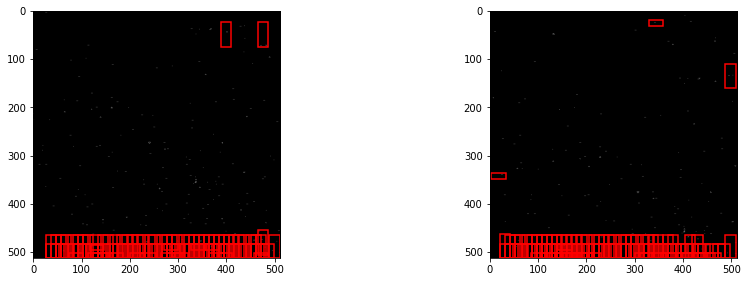

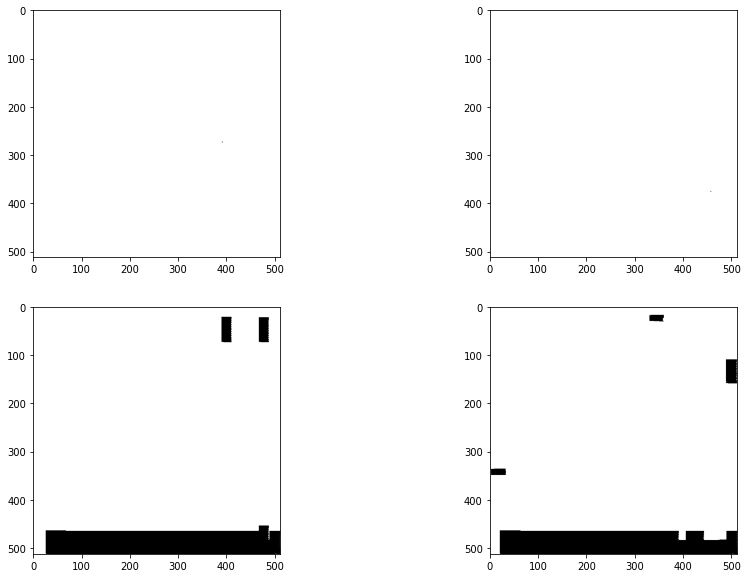

In [17]:
images, targets =  next(iter(data_loader_val))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

model.eval()
output = model(images)

with torch.no_grad():
    view(images, output, 2)
    view_mask(targets, output, 2)